<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_surgery_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1y8OFnIFYC_b_WIexKSog732_L78Pegxa/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa
From (redirected): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa&confirm=t&uuid=42c42b48-8df4-4032-ab01-57c7d2a9d342
To: /content/brain_small.zip
100% 119M/119M [00:01<00:00, 68.5MB/s]


In [2]:
!unzip -q brain_small.zip

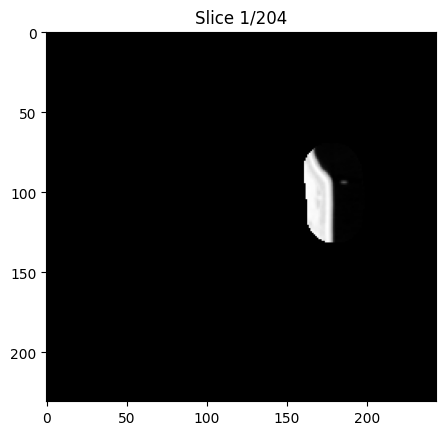

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from monai.transforms import LoadImage
import os

# 加載 NIfTI 檔案
nii_file = "/content/1BA001/ct.nii.gz"

# 確認檔案是否存在
if not os.path.exists(nii_file):
    raise FileNotFoundError(f"檔案 {nii_file} 不存在，請確認路徑是否正確。")

# 使用 MONAI 加載影像
image_loader = LoadImage(image_only=True)
image = image_loader(nii_file)

# 設置動畫顯示
fig, ax = plt.subplots()
slice_display = ax.imshow(image[:, :, 0], cmap="gray")
title = ax.set_title("Slice 1")

# 更新每一幀的內容
def update(slice_index):
    slice_display.set_data(image[:, :, slice_index])
    title.set_text(f"Slice {slice_index + 1}/{image.shape[-1]}")
    return slice_display, title

# 動畫設置
anim = FuncAnimation(fig, update, frames=image.shape[-1], interval=100, blit=True)
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import DropPath

# Smoothed Dilated Convolution
class SmoothedDilatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=2):
        super(SmoothedDilatedConv, self).__init__()
        self.separable_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.dilated_conv = nn.Conv3d(out_channels, out_channels, kernel_size, dilation=dilation, padding=dilation, bias=False)
        self.norm = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.separable_conv(x)
        x = self.dilated_conv(x)
        x = self.norm(x)
        return F.relu(x)

# Swin Transformer Block
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
        self.drop_path = DropPath(0.1)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        # Reshape input for multi-head self-attention
        B, C, H, W, D = x.shape
        x = x.view(B, -1, C)  # Flatten for MSA
        attn_output, _ = self.attn(x, x, x)
        x = x + self.drop_path(attn_output)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x.view(B, C, H, W, D)

# Residual Dilated Swin Transformer Block
class RDSformerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads=8, window_size=7):
        super(RDSformerBlock, self).__init__()
        self.smooth_dilated = SmoothedDilatedConv(in_channels, out_channels)
        self.swin_transformer = SwinTransformerBlock(out_channels, num_heads, window_size)
        self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.residual(x)
        x = self.smooth_dilated(x)
        x = self.swin_transformer(x)
        return x + residual

# UNet with RDSformer Blocks
class UNetWithRDSformer(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=64, num_heads=8, window_size=7):
        super(UNetWithRDSformer, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv3d(in_channels, base_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv3d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv3d(base_channels * 2, base_channels * 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.output_layer = nn.Conv3d(base_channels, out_channels, kernel_size=1)

        # Skip connections with RDSformer
        self.rdsformer1 = RDSformerBlock(base_channels, base_channels, num_heads, window_size)
        self.rdsformer2 = RDSformerBlock(base_channels * 2, base_channels * 2, num_heads, window_size)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # First encoding layer
        enc2 = self.encoder2(enc1)  # Second encoding layer

        # Bottleneck
        bottleneck = self.bottleneck(enc2)

        # Decoder
        dec2 = self.decoder2(bottleneck) + self.rdsformer2(enc2)  # Add RDSformer-enhanced skip connection
        dec1 = self.decoder1(dec2) + self.rdsformer1(enc1)  # Add RDSformer-enhanced skip connection

        # Output
        output = self.output_layer(dec1)
        return output


In [22]:
# !git clone https://github.com/SynthRAD2023/preprocessing.git

In [24]:
import torch
from monai.transforms import LoadImage, EnsureChannelFirst, ScaleIntensity, Resize

# 加載和處理測試數據
def load_test_data(nii_file, target_size=(128, 128, 128)):
    loader = LoadImage(image_only=True)
    image = loader(nii_file)  # 加載 NIfTI 文件
    image = ScaleIntensity()(image)  # 歸一化
    image = Resize(spatial_size=target_size)(image)  # 重設大小
    image = EnsureChannelFirst()(image)  # 確保通道在第 1 維 (C, D, H, W)
    image = image.clone().detach().float()  # 使用 clone 和 detach，避免警告
    image = image.unsqueeze(0)  # 添加批次維度 (B, C, D, H, W)
    return image

# 測試數據路徑
nii_file = "/content/data/1BA001/ct.nii.gz"  # 替換為你的 NIfTI 文件路徑
test_data = load_test_data(nii_file)
# 檢查數據形狀
# 修正多餘維度
if test_data.ndim == 6:  # 如果形狀是 [1, 1, 231, 128, 128, 128]
    test_data = test_data.squeeze(2)  # 壓縮維度
print(f"Test data shape: {test_data.shape}")  # 應該是 [1, 1, D, H, W]

# 模型初始化
in_channels = 1  # MRI 通道數
out_channels = 1  # CT 通道數
model = UNetWithRDSformer(in_channels=in_channels, out_channels=out_channels)

# 模型前向傳播
output = model(test_data)
print(f"Output shape: {output.shape}")  # 應該是 [B, C, D, H, W]


Test data shape: torch.Size([1, 1, 231, 128, 128, 128])


RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [1, 1, 231, 128, 128, 128]